In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.applications import VGG16
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Configurar TensorFlow para usar la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
# Definir rutas de las carpetas que contienen las imágenes
directorio = "../../../../split_imagenes/cmor/"
img_width, img_height = 250, 250
input_shape = (img_width, img_height, 3)

# Hiperparámetros
epochs = 100
batch_size = 16

In [8]:
# Configurar el generador de datos de imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagem = ImageDataGenerator(rescale=1./255)
test_datagem = ImageDataGenerator(rescale=1./255)

#Directorios de las imágenes
train_dir = "../../../../split_imagenes/cmor/train/"
valid_dir = "../../../../split_imagenes/cmor/val/"
test_dir = "../../../../split_imagenes/cmor/test/"

# Cargar y dividir los datos en conjuntos de entrenamiento y prue
generador_entrenamiento = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Cargar imágenes de validación
generador_validacion = valid_datagem.flow_from_directory(
    valid_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Cargar imágenes de prueba
generador_prueba = test_datagem.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',  # 'categorical' para más de dos clases
    shuffle=False  # No mezclar las imágenes de prueba para mantener el orden
)



Found 3200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [9]:
# Cargar el modelo ResNet50 pre-entrenado sin la parte superior (include_top = False)
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar las capas de la ResNet50 pre-entrenada
for layer in vgg16_model.layers:
    layer.trainable = False

In [10]:
# Construir el modelo
model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
#Se define un callback para guardar el mejor modelo basado en el val_accuracy
checkpoint_callback = ModelCheckpoint(
    filepath = "modelo_generado/mejor_modelo.keras",
    monitor = "val_loss",
    save_best_only = True,
    mode = "min",
    verbose = 1
)

# Entrenar el modelo
historia = model.fit(
    generador_entrenamiento,
    steps_per_epoch=generador_entrenamiento.samples // batch_size,
    epochs=epochs,
    validation_data=generador_validacion,
    validation_steps=generador_validacion.samples // batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.7034 - accuracy: 0.6544
Epoch 1: val_loss improved from inf to 0.56056, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 32s 127ms/step - loss: 0.7034 - accuracy: 0.6544 - val_loss: 0.5606 - val_accuracy: 0.7275
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.7287
Epoch 2: val_loss improved from 0.56056 to 0.49198, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 26s 129ms/step - loss: 0.5231 - accuracy: 0.7287 - val_loss: 0.4920 - val_accuracy: 0.7825
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.7538
Epoch 3: val_loss improved from 0.49198 to 0.46145, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 27s 132ms/step - loss: 0.4911 - accuracy: 0.7538 - val_loss: 0.4614 - val_accuracy: 0.7900
Ep

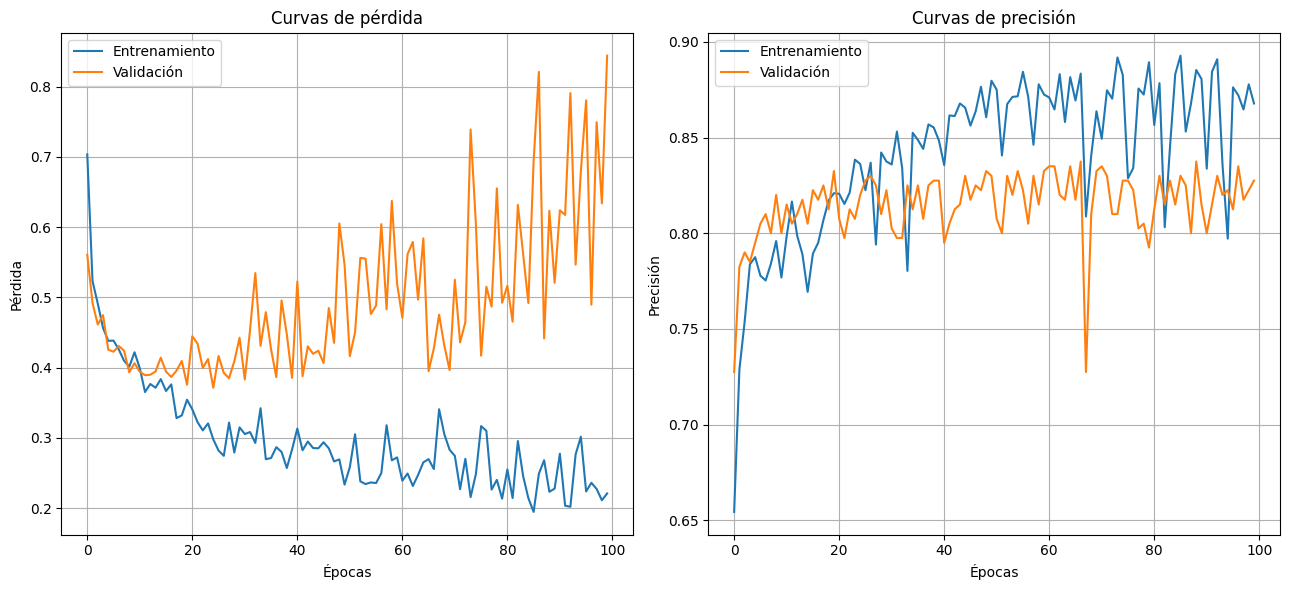

In [12]:
# Curvas de pérdida
plt.figure(figsize=(13,6))
plt.subplot(1, 2, 1)
plt.plot(historia.history['loss'], label='Entrenamiento')
plt.plot(historia.history['val_loss'], label='Validación')
plt.title('Curvas de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()

# Curvas de precisión
plt.subplot(1, 2, 2)
plt.plot(historia.history['accuracy'], label='Entrenamiento')
plt.plot(historia.history['val_accuracy'], label='Validación')
plt.title('Curvas de precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## **Parte 5:** Evaluación del modelo

Se evalua el mejor modelo guardado

In [13]:
mejor_modelo = load_model("modelo_generado/mejor_modelo.keras")
generador_validacion.reset()
resul_eva = mejor_modelo.evaluate(generador_validacion, verbose=False)

print("Perdida: {:.2f}".format(resul_eva[0]))
print("Accuracy: {:.2%}".format(resul_eva[1]))

Perdida: 0.37
Accuracy: 82.00%


Cálculo de diferentes métricas


Matriz de Confusión:


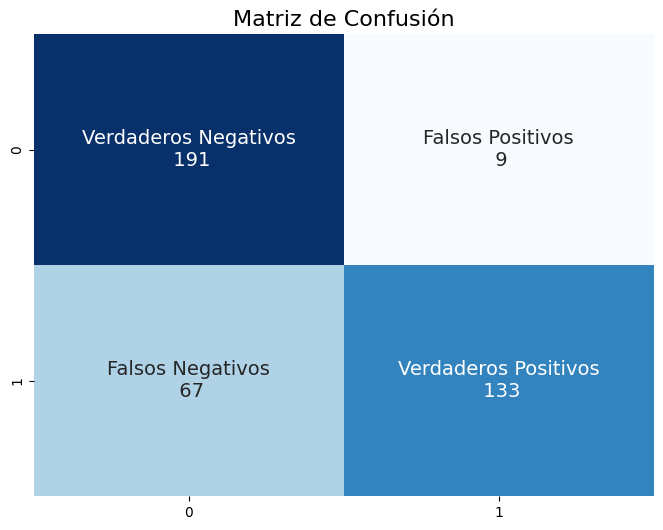

Accuracy:	81.00%
Sensitivity:	66.50%
Specificity:	95.50%
Precision:	93.66%
F1-score:	77.78%


In [14]:
# Obtener las predicciones del modelo
y_pred_prob = mejor_modelo.predict(generador_prueba, verbose=False)

# Convertir las probabilidades en clases binarias usando un umbral (por ejemplo, 0.85)
y_pred = (y_pred_prob > 0.7).astype(int)

# Obtener las etiquetas verdaderas
y_test = generador_validacion.classes

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calcular sensitivity y specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Imprimir resultados
print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matrix)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

print("Accuracy:\t{:.2%}".format(accuracy))
print("Sensitivity:\t{:.2%}".format(sensitivity))
print("Specificity:\t{:.2%}".format(specificity))
print("Precision:\t{:.2%}".format(precision))
print("F1-score:\t{:.2%}".format(f1))